In [1]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [23]:
from google.colab import drive
import os

# Mount Google Drive
drive.mount('/gdrive', force_remount=True)


Mounted at /gdrive


In [3]:
from google.colab import drive
import os
# Location of Zip File
drive_path = '/gdrive/MyDrive/Politeknik/Semester 4/Data Science/L6P2/flowers.zip'
local_path = '/content'



In [4]:
# Copy the zip file and move it up one level (AKA out of the drive folder)
!cp '{drive_path}' .
# Navigate to the copied file and unzip it quietly


In [7]:
os.chdir(local_path)
!unzip -q 'flowers.zip'

In [8]:
import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf

IMG_HEIGHT = 224
IMG_WIDTH = 224
IMG_CHANNELS = 3

def read_and_decode(filename, reshape_dims):
  # Read the file
  img = tf.io.read_file(filename)
  # Convert the compressed string to a 3D uint8 tensor.
  img = tf.image.decode_jpeg(img, channels=IMG_CHANNELS)

  # img = tf.image.decode_image(img, channels=IMG_CHANNELS, expand_animations=False)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # img = tf.resize_images_v2(img, reshape_dims, method="bilinear")
  # return img.set_shape((image_size[0], image_size[1], num_channels))

  # Resize the image to the desired size.
  #img = tf.image.resize(img, reshape_dims) #[244,244] using image module for resizing,
  #must also apply on testing and validation dataset
  return img

  ##add prediction and preprocessing

#change regex pattern from PetImages\\ to PetImages/
#extract your class labels from folder name
pattern = r'train/'
print(tf.io.gfile.glob("train/*"))
CLASS_NAMES = [item.numpy().decode("utf-8") for item in
               tf.strings.regex_replace(
                 tf.io.gfile.glob("train/*"), #input
                 pattern, "")]
                  #pattern, "" -the new value replacing the input that match the pattern
print(CLASS_NAMES)
CLASS_NAMES = [item for item in CLASS_NAMES if item.find(".") == -1]
print("These are the available classes:", CLASS_NAMES)

['train/tulip', 'train/sunflower', 'train/dandelion', 'train/daisy', 'train/rose']
['tulip', 'sunflower', 'dandelion', 'daisy', 'rose']
These are the available classes: ['tulip', 'sunflower', 'dandelion', 'daisy', 'rose']


In [9]:
#create a list of filenames with its class labels
import pandas as pd

flowersdf = pd.DataFrame(columns=['path', 'class'])
absolutePath = r"train/"

#dynamic link
for i in CLASS_NAMES:

    classPath = tf.io.gfile.glob(absolutePath+ i +"/*.jpg")
    #absolutepath /train/sunflowers/* - all datasets

    paths_df = pd.DataFrame({'path': classPath})
    # Add a column with the current class name
    paths_df['class'] = i

    flowersdf = pd.concat([flowersdf, paths_df], ignore_index=True)

print(flowersdf)

                                          path  class
0     train/tulip/18270448366_d5676dec64_z.jpg  tulip
1      train/tulip/5631861819_f0eb39a357_m.jpg  tulip
2      train/tulip/8673412732_f8fd690ee4_n.jpg  tulip
3     train/tulip/13979098015_e8c98fd34e_n.jpg  tulip
4        train/tulip/5698944116_fd35fe6bea.jpg  tulip
...                                        ...    ...
2741     train/rose/19919867648_043cf02fc3.jpg   rose
2742    train/rose/3705716290_cb7d803130_n.jpg   rose
2743      train/rose/5777669976_a205f61e5b.jpg   rose
2744   train/rose/17062080069_36ac7907d2_n.jpg   rose
2745    train/rose/8523394349_61b31fdd8f_m.jpg   rose

[2746 rows x 2 columns]


In [10]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(flowersdf["path"], flowersdf["class"],test_size=0.20)

# Create DataFrames from the split data
X_train_df = pd.DataFrame(X_train, columns=["path"])
X_test_df = pd.DataFrame(X_test, columns=["path"])

# Concatenate paths and labels for training and testing data
trainData = pd.concat([X_train_df, y_train], axis=1)
testData = pd.concat([X_test_df, y_test], axis=1)

trainData.to_csv("train.csv",index=False, header=False)
testData.to_csv("test.csv",index=False, header=False)
print(trainData)

                                              path      class
981   train/sunflower/21796333524_38fc8e0ab5_n.jpg  sunflower
1556    train/dandelion/13887066460_64156a9021.jpg  dandelion
1698     train/dandelion/6994938270_bf51d0fe63.jpg  dandelion
1776       train/daisy/2511306240_9047015f2d_n.jpg      daisy
2003      train/daisy/21402054779_759366efb0_n.jpg      daisy
...                                            ...        ...
1002     train/sunflower/5923649444_a823e534e9.jpg  sunflower
2274         train/rose/13231224664_4af5293a37.jpg       rose
277         train/tulip/13472141763_f2517e7f0d.jpg      tulip
834      train/sunflower/9610371852_179e7781ce.jpg  sunflower
1665    train/dandelion/17244252705_328e0bcda6.jpg  dandelion

[2196 rows x 2 columns]


In [11]:
def decode_csv(csv_row):
  record_defaults = ["path", "flower"]
  filename, label_string = tf.io.decode_csv(csv_row, record_defaults)
  img = read_and_decode(filename, [IMG_HEIGHT, IMG_WIDTH])
  label = tf.argmax(tf.math.equal(CLASS_NAMES, label_string))
  return img, label

In [12]:
train_dataset = (tf.data.TextLineDataset(
    "train.csv").
    map(decode_csv)).batch(10)

eval_dataset = (tf.data.TextLineDataset(
    "test.csv").
    map(decode_csv)).batch(10)

print(train_dataset)
print(eval_dataset)

<_BatchDataset element_spec=(TensorSpec(shape=(None, None, None, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>
<_BatchDataset element_spec=(TensorSpec(shape=(None, None, None, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>


['train/daisy/4222584034_8964cbd3de.jpg', 'train/daisy/6148728633_27afc47b0c_m.jpg', 'train/daisy/18582579815_4c6637e9ff_m.jpg', 'train/daisy/9094631844_1a6abca29e.jpg', 'train/daisy/4858518329_7563eb0baa_m.jpg', 'train/daisy/6136947177_47ff445eb4_n.jpg', 'train/daisy/17357636476_1953c07aa4_n.jpg', 'train/daisy/6978826370_7b9aa7c7d5.jpg', 'train/daisy/3450822975_7e77d67636_n.jpg', 'train/daisy/4540555191_3254dc4608_n.jpg', 'train/daisy/2621723097_736febb4a4_n.jpg', 'train/daisy/5795159787_ebb51a5e75.jpg', 'train/daisy/8708143485_38d084ac8c_n.jpg', 'train/daisy/3483303007_42e3f90da7.jpg', 'train/daisy/9321854387_5f77c926cb_n.jpg', 'train/daisy/3310644753_5607eb96a4_m.jpg', 'train/daisy/8932490012_cc08e690ba_n.jpg', 'train/daisy/14114116486_0bb6649bc1_m.jpg', 'train/daisy/9345273630_af3550031d.jpg', 'train/daisy/14716799982_ed6d626a66.jpg', 'train/daisy/11023277956_8980d53169_m.jpg', 'train/daisy/4482623536_b9fb5ae41f_n.jpg', 'train/daisy/8127252886_96558c23d1.jpg', 'train/daisy/14591326

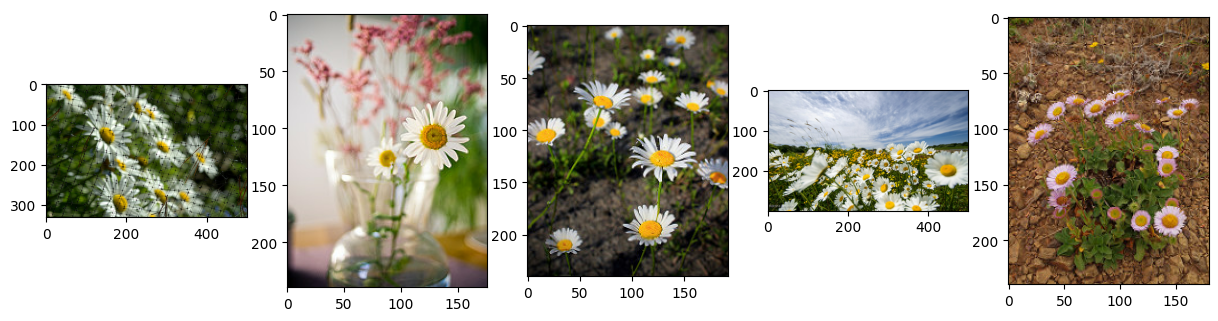

In [13]:
flowers = tf.io.gfile.glob("train/daisy/*.jpg")
f, ax = plt.subplots(1, 5, figsize=(15,15))
print(flowers)
for idx, filename in enumerate(flowers[:5]):
  print(filename)
  print(idx)
  img = read_and_decode(filename, [IMG_HEIGHT, IMG_WIDTH])
  ax[idx].imshow((img.numpy()));
  ax[idx].axis('on')
  #resizing hide

In [14]:
def plotimages():
  f, ax = plt.subplots(1, 5, figsize=(15,15))
  for idx, (img, label) in enumerate(train_dataset.take(5)):
      # Plot the images
      plt.figure(figsize=(4, 4))
      ax[idx].imshow((img.numpy())) # Convert the tensor to NumPy array for plotting
      #ax[idx].set_title(f"Label: {label.numpy()}")
      ax[idx].set_title(CLASS_NAMES[label.numpy()])
      ax[idx].axis("on")



In [15]:
#Resizing
preproc_layers = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.Resizing(
  height=IMG_HEIGHT, width=IMG_WIDTH,
  input_shape=(None, None, 3))
  ])
# train_dataset.map(lambda img: preproc_layers(img))
# However, this won’t work because the train_dataset provides a tuple (img, label)
# where the image is a 3D tensor (height, width, channels) while the Keras Sequential
# model expects a 4D tensor (batchsize, height, width, channels).


In [20]:
#resizing
def apply_preproc(img, label):
    # add to a batch, call preproc, remove from batch
    print(x)
    x = tf.expand_dims(img, 0)
    print(x)
    x = preproc_layers(x)
    print(x)
    x = tf.squeeze(x, 0)
    print(x)
    return x, label

Tensor("ExpandDims:0", shape=(1, None, None, 3), dtype=float32)
Tensor("sequential/resizing/resize/ResizeBilinear:0", shape=(1, 224, 224, 3), dtype=float32)
Tensor("Squeeze:0", shape=(224, 224, 3), dtype=float32)


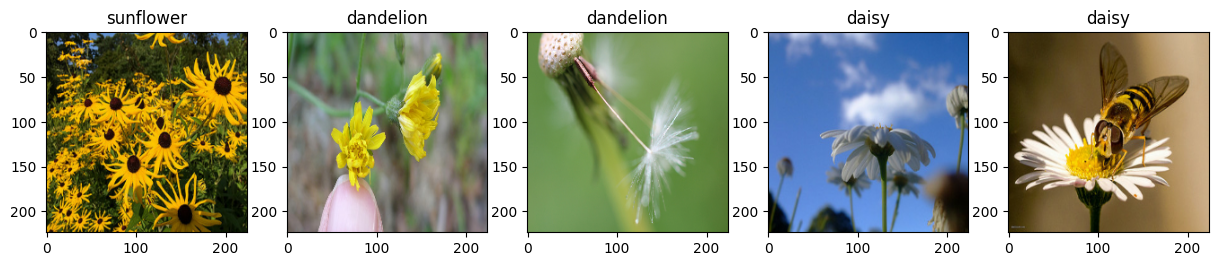

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

In [21]:
def apply_preproc(img, label):
  # add to a batch, call preproc, remove from batch
  x = tf.expand_dims(img, 0)
  print(x)
  x = preproc_layers(x)
  print(x)
  x = tf.squeeze(x, 0)
  print(x)
  return x, label
train_dataset = (tf.data.TextLineDataset(
    "train.csv").map(decode_csv)).map(apply_preproc)
plotimages()


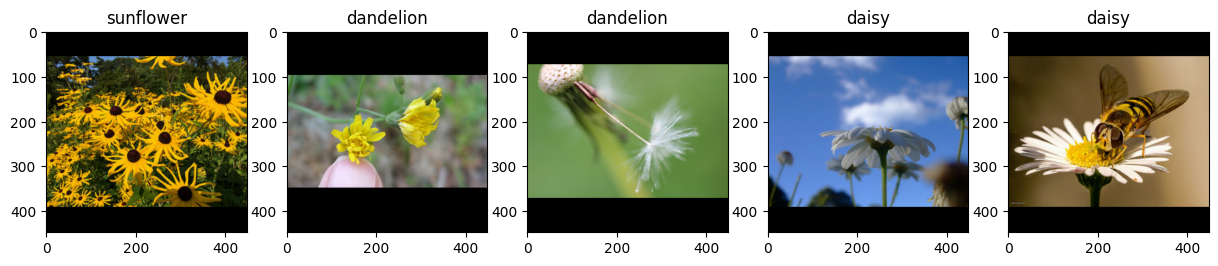

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

In [18]:
#padding
def apply_preproc2(img, label):
    return tf.image.resize_with_pad(img, 2*IMG_HEIGHT, 2*IMG_WIDTH), label

train_dataset = (tf.data.TextLineDataset(
    "train.csv").
    map(decode_csv)).map(apply_preproc2)
plotimages()

In [ ]:
#using tensorflow image module
# img = tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH)], preserve_aspect_ratio=True)
# img = tf.image.resize_with_pad(img, [IMG_HEIGHT, IMG_WIDTH)])

In [ ]:
#same as above
def apply_preproc3(img, label):
    # add to a batch, call preproc, remove from batch
    x = tf.expand_dims(img, 0)
    x = preproc_layers(x)
    x = tf.squeeze(x, 0)
    return x, label
#update preproc_layers to have centercrop and size with pad
preproc_layers = tf.keras.Sequential([
    tf.keras.layers.Lambda(lambda img:
                           tf.image.resize_with_pad(
                               img, 2*IMG_HEIGHT, 2*IMG_WIDTH),
                           input_shape=(None, None, 3)),
    tf.keras.layers.experimental.preprocessing.CenterCrop(
        height=IMG_HEIGHT, width=IMG_WIDTH)
    ])

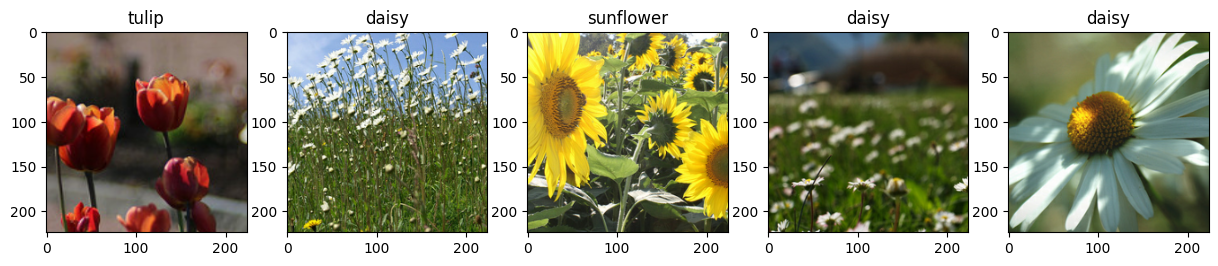

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

In [ ]:
train_dataset = (tf.data.TextLineDataset(
    "train.csv").
    map(decode_csv).map(apply_preproc3))
plotimages()

In [ ]:
def training_plot(metrics, history):
    f, ax = plt.subplots(1, len(metrics), figsize=(15,5))
    for idx, metric in enumerate(metrics):
        ax[idx].plot(history.history[metric])
        ax[idx].set_xlabel("Epochs")
        # ax[idx].set_ylabel(metric, fontweight='bold', fontsize=20)
        ax[idx].plot(history.history['val_' + metric], ls='dashed');
        ax[idx].legend([metric, 'val_' + metric], fontsize=20)

In [ ]:
import tensorflow_hub as hub
def train_and_evaluate(batch_size = 10,
                       lrate = 0.001,
                       l1 = 0.,
                       l2 = 0.,
                       num_hidden = 16):
  regularizer = tf.keras.regularizers.l1_l2(l1, l2)
  train_dataset = (tf.data.TextLineDataset(
    "train.csv").
    map(decode_csv).map(apply_preproc3).batch(batch_size))
  eval_dataset = (tf.data.TextLineDataset(
    "test.csv").
    map(decode_csv).map(apply_preproc3).batch(batch_size))

  layers = [
        hub.KerasLayer(
            "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4",
            input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS),
            trainable=False,
            name='mobilenet_embedding'),
        tf.keras.layers.Dense(num_hidden,
                              kernel_regularizer=regularizer,
                              activation=tf.keras.activations.relu,
                              name='dense_hidden'),
        tf.keras.layers.Dense(len(CLASS_NAMES),
                              kernel_regularizer=regularizer,
                              activation='softmax',
                              name='flower_prob')
    ]
  model = tf.keras.Sequential(layers, name='flower_classification')
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lrate),
                loss=tf.keras.losses.SparseCategoricalCrossentropy(
                    from_logits=False),
                metrics=['accuracy'])
  print(model.summary())
  history = model.fit(train_dataset, validation_data=eval_dataset, epochs=5)
  training_plot(['loss', 'accuracy'], history)
  return model

Model: "flower_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_embedding (Keras  (None, 1280)              2257984   
 Layer)                                                          
                                                                 
 dense_hidden (Dense)        (None, 16)                20496     
                                                                 
 flower_prob (Dense)         (None, 5)                 85        
                                                                 
Total params: 2278565 (8.69 MB)
Trainable params: 20581 (80.39 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________
None
Epoch 1/5
220/220 [==============================] - 144s 633ms/step - loss: 0.7705 - accuracy: 0.7204 - val_loss: 0.4364 - val_accuracy: 0.8436
Epoch 2/5
220/220 [==============================] -

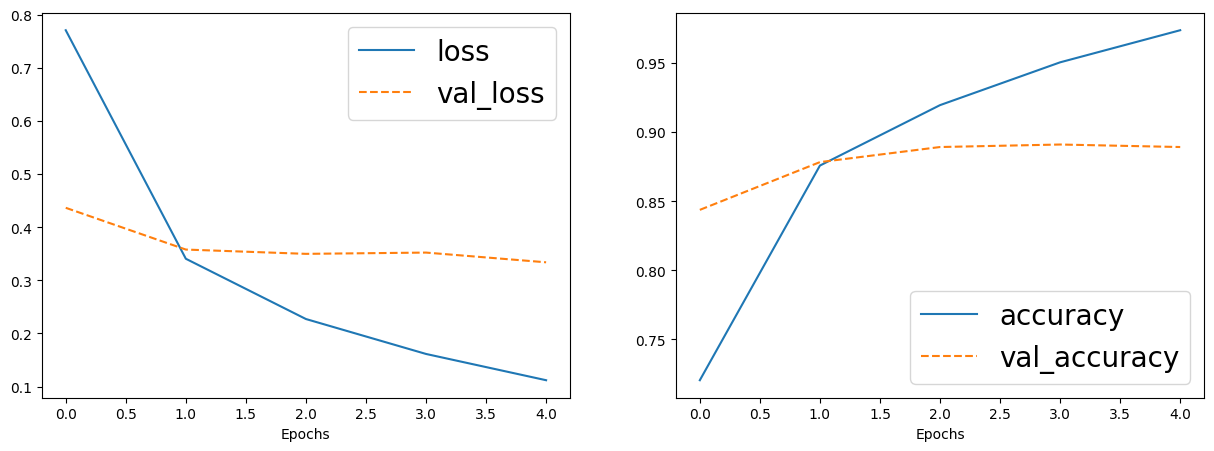

In [ ]:
model = train_and_evaluate()